In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, auc
from sklearn.metrics import roc_auc_score

In [4]:
%matplotlib inline
plt.style.use('bmh')
sns.set_theme(style="whitegrid")

In [5]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, split, length, initcap, trim, lower, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [6]:
spark = SparkSession.builder \
    .appName("Clustering") \
    .getOrCreate()

spark

24/11/20 22:33:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [8]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

In [9]:
pandas_ip_df = ip_data.toPandas()

24/11/20 22:33:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Clustering Using KMeans

- Identify clusters with high fatalities or injuries.
- Recognize patterns in gun types or participant demographics.
- Pinpoint clusters associated with specific states or regions.

In [11]:
features = [
    'n_killed', 'n_injured', 'gun_stolen_not_stolen_freq', 'gun_stolen_stolen_freq',
    'gun_type_handgun_freq', 'gun_type_rifle_freq', 'participant_gender_female_freq',
    'participant_gender_male_freq', 'participant_status_killed_freq'
]

X = pandas_ip_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

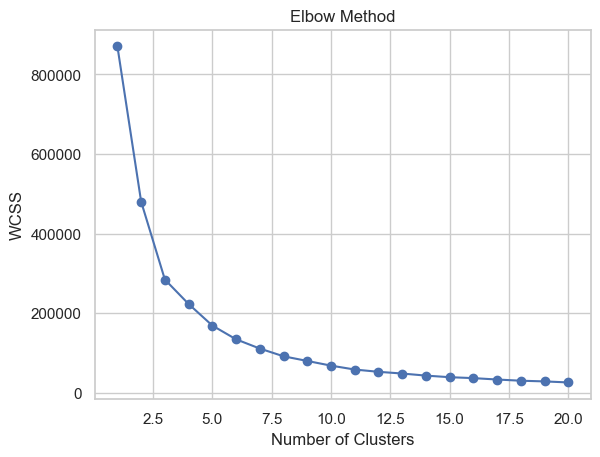

In [12]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [13]:
optimal_clusters = 8
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

pandas_ip_df['cluster'] = clusters

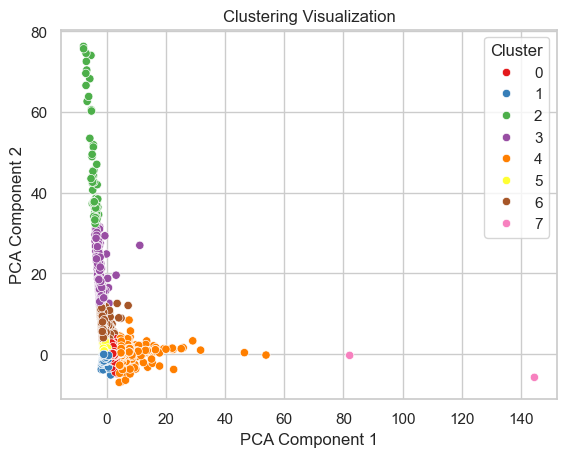

In [14]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Visualization')
plt.legend(title='Cluster')
plt.show()

In [15]:
cluster_summary = pandas_ip_df.groupby('cluster')[features].mean()

In [16]:
print(cluster_summary)

          n_killed  n_injured  gun_stolen_not_stolen_freq  \
cluster                                                     
0         0.987828   0.219254                    0.003513   
1         0.000006   0.623005                    0.000116   
2         0.000000   0.031250                    0.421875   
3         0.014388   0.000000                    0.305755   
4         2.196082   0.356829                    0.007689   
5         0.000000   0.187731                    0.066125   
6         0.017129   0.035073                    0.095432   
7        38.500000  36.500000                    1.000000   

         gun_stolen_stolen_freq  gun_type_handgun_freq  gun_type_rifle_freq  \
cluster                                                                       
0                      0.005473               0.048585             0.008046   
1                      0.001628               0.002467             0.000043   
2                     22.000000              24.687500             6.1718

**Cluster 0:**

- Key Stats: Close to 1 person killed (0.987), very few injured (0.219), and a negligible frequency of guns being stolen or not stolen.
- Gun Type: Slight frequency of handguns (0.048) and rifles (0.008).
- Demographics: Male participants dominate (1.615) over females (0.220).
- Outcome: Majority of incidents involve at least one person killed (0.987 frequency).
- Interpretation: Likely represents single-victim fatal incidents with minimal injuries and low reporting of gun types or thefts.

**Cluster 1:**

- Key Stats: Almost no fatalities (0.000006) but moderate injuries (0.623).
- Gun Type: Negligible use of handguns or rifles.
- Demographics: Male participants (1.177) slightly outnumber females (0.149).
- Outcome: Minimal deaths but some injuries.
- Interpretation: Possibly represents non-lethal incidents, like shootings where no one was killed but injuries occurred.

**Cluster 2:**

- Key Stats: No fatalities or injuries (both near 0).
- Gun Type: High presence of handguns (24.687), rifles (6.171), and stolen guns (22.0 frequency).
- Demographics: Slight male dominance (1.250).
- Interpretation: Likely represents incidents involving weapon confiscations or reports without casualties or injuries.

**Cluster 3:**

- Key Stats: Very few fatalities (0.014) and no injuries.
- Gun Type: Moderate frequency of stolen guns (14.67) and handguns (5.67).
- Demographics: Male participants more frequent (1.467) than females (0.115).
- Outcome: Incidents where guns are stolen or seized, possibly without any violence.
- Interpretation: Theft-related incidents or non-violent gun recoveries.

**Cluster 4:**

- Key Stats: Relatively high fatalities (2.196) and moderate injuries (0.357).
- Gun Type: Slightly higher use of handguns (0.074) and rifles (0.016).
- Demographics: Higher male (2.056) and female (0.875) participant frequencies.
- Outcome: Multiple fatalities and injuries in these incidents.
- Interpretation: Likely represents high-casualty events like mass shootings.

**Cluster 5:**

- Key Stats: No fatalities and some injuries (0.188).
- Gun Type: High handgun involvement (0.785) and moderate rifles (0.100).
- Demographics: Male participants dominate (1.196), with some females (0.143).
- Outcome: Non-lethal incidents with moderate injuries and notable gun type usage.
- Interpretation: May involve accidental discharges or less severe altercations.

**Cluster 6:**

- Key Stats: Minimal fatalities (0.017) and injuries (0.035).
- Gun Type: Moderate frequencies of handguns (2.253) and rifles (1.225).
- Demographics: Male participants (1.293) slightly more than females (0.174).
- Outcome: Incidents with minor fatalities/injuries and varied gun use.
- Interpretation: A mix of small-scale violent and non-violent events.

**Cluster 7:**

- Key Stats: Extremely high fatalities (38.5) and injuries (36.5).
- Gun Type: Only rifles (0.5 frequency), no handguns.
- Demographics: Large numbers of male (40.0) and female (20.0) participants.
- Outcome: Mass casualty events with very high fatalities and injuries.
- Interpretation: Likely represents incidents like mass shootings or large-scale violent events.

In [19]:
pandas_ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 46 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   incident_id                              239677 non-null  int32  
 1   date                                     239677 non-null  object 
 2   state                                    239677 non-null  object 
 3   city_or_county                           239677 non-null  object 
 4   address                                  239677 non-null  object 
 5   n_killed                                 239677 non-null  int32  
 6   n_injured                                239677 non-null  int32  
 7   congressional_district                   239677 non-null  int32  
 8   incident_characteristics                 239677 non-null  object 
 9   latitude                                 239677 non-null  float64
 10  longitude                       